In [1]:
#import libraries

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Check datasize and period for splitting

row_number = 1685 #prior data info
df = pd.read_csv('PowerFactor_revised.csv', skiprows = [i for i in range (1, row_number+2)])
df.set_index('DeviceTimeStamp', inplace = True)
df['Date'] = df.index
x = df['Date']
y1 = df['PFL1']

print(df.shape)
print(x.min(), x.max())

(17622, 17)
2019-07-13T12:05 2020-04-14T00:30


Power factor from line 1 considered for forecast model, power factors from other 2 lines can be similarly treated.

In [3]:
#Split data into train and test (roughly 90%:10% ratio) with variables considered for modeling

train = df[['PFL1', 'THDVL1', 'MDIL1']].loc['2019-07-13T12:05':'2020-03-07T00:15']
test = df[['PFL1', 'THDVL1', 'MDIL1']].loc['2020-03-21T14:41':] 
print(train.shape, test.shape)
print("Train % =", round(((len(train)/len(df))*100), 2))
print("Test % =", round(((len(test)/len(df))*100), 2))
print("Mean: ", round(np.mean(train), 2))

#train, test = x.iloc[].copy(), x.iloc[].copy()

(15610, 3) (2012, 3)
Train % = 88.58
Test % = 11.42
Mean:  PFL1        0.99
THDVL1      1.83
MDIL1     161.68
dtype: float64


Text(0.5, 1.0, 'Training data')

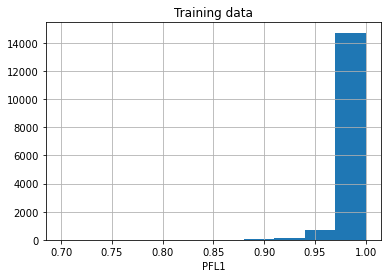

In [4]:
train['PFL1'].hist() #dependent variable
plt.xlabel('PFL1')
plt.title('Training data')

In [5]:
test.describe()

,PFL1,THDVL1,MDIL1
count,2012.000000,2012.000000,2012.000000
mean,0.988857,1.710686,115.037922
std,0.004425,0.389966,27.110866
min,0.900000,0.300000,0.000000
25%,0.990000,1.400000,95.100000
50%,0.990000,1.700000,95.400000
75%,0.990000,2.000000,147.300000
max,0.990000,2.700000,147.300000


A stationary series has no trend, its variations around its mean have a constant amplitude, it wiggles in a consistent fashion (short-term pattern looks the same statistically speaking). 

In [6]:
#Checking mean & variance does not vary with time (stationary, in other words)

s = train['PFL1'].values
split = int(len(s)/2)
s1, s2 = s[0:split], s[split:]
mean1, mean2 = s1.mean(), s2.mean()
var1, var2 = s1.var(), s2.var()

print('Avg1 = %f, Avg2 = %f' % (mean1, mean2))
print('Var1 = %f, Var2 = %f' % (var1, var2))

Avg1 = 0.984186, Avg2 = 0.986336
Var1 = 0.000130, Var2 = 0.000232


In [7]:
#Initiate Vector Auto Regression model for multivariate time-series

model = VAR(endog = train)
res = model.select_order(10) 
res.summary()

,AIC,BIC,FPE,HQIC
0,-2.200,-2.198,0.1108,-2.199
1,-8.336,-8.330,0.0002397,-8.334
2,-8.633,-8.623,0.0001782,-8.629
3,-8.774,-8.760,0.0001547,-8.769
4,-8.887,-8.868,0.0001381,-8.881
5,-8.901,-8.877,0.0001363,-8.893
6,-8.906,-8.878*,0.0001356,-8.897
7,-8.908,-8.876,0.0001353,-8.897
8,-8.909,-8.872,0.0001352,-8.897
9,-8.909,-8.868,0.0001352,-8.895


In [8]:
#Fit to VAR model #lag order=5
model_fit = model.fit(maxlags = 5) #following partial autocorrelation info

#Model summary
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 31, Jan, 2022
Time:                     11:35:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.80008
Nobs:                     15605.0    HQIC:                  -8.81583
Log likelihood:           2466.75    FPE:                0.000147213
AIC:                     -8.82363    Det(Omega_mle):     0.000146761
--------------------------------------------------------------------
Results for equation PFL1
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.107683         0.005792           18.591           0.000
L1.PFL1           0.302701         0.008004           37.819           0.000
L1.THDVL1         0.000645         0.000197            3.270           0.001


In [15]:
#Forecast on test data

forecast = model_fit.forecast(model_fit.y, steps = len(test))

cols = ['PFL1_forecast', 'THDVL1_forecast', 'MDIL1_forecast']
dff = pd.DataFrame(forecast, index = test.index, columns = cols)
#dff.head(30)

dfc = pd.concat([dff, test])
dfc


,PFL1_forecast,THDVL1_forecast,MDIL1_forecast,PFL1,THDVL1,MDIL1
DeviceTimeStamp,,,,,,
2020-03-21T14:41,0.989494,2.007436,129.288171,NaN,NaN,NaN
2020-03-21T14:45,0.989394,1.990528,129.399804,NaN,NaN,NaN
2020-03-21T15:00,0.989256,1.981724,129.536357,NaN,NaN,NaN
2020-03-21T15:15,0.989164,1.970981,129.674822,NaN,NaN,NaN
2020-03-21T15:30,0.988983,1.968154,129.793858,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-04-13T23:30,NaN,NaN,NaN,0.99,1.8,95.4
2020-04-13T23:45,NaN,NaN,NaN,0.99,1.7,95.4
2020-04-14T00:00,NaN,NaN,NaN,0.99,1.5,95.4


In [12]:
dff[['PFL1_forecast', 'THDVL1_forecast', 'MDIL1_forecast']].describe()

,PFL1_forecast,THDVL1_forecast,MDIL1_forecast
count,2012.000000,2012.000000,2012.000000
mean,0.985374,1.840754,159.187827
std,0.000376,0.028436,7.782433
min,0.985239,1.823542,129.288171
25%,0.985241,1.823982,158.354715
50%,0.985257,1.826725,163.057137
75%,0.985351,1.843796,163.812641
max,0.989494,2.007436,163.934022


In [19]:
##Plot & compare

#plt.figure(figsize = (14, 7))
#plt.xlabel('Date')

#ax1 = test['PFL1'].plot(color = 'blue', label = 'Actual PFL1')
#ax2 = dff['PFL1_forecast'].plot(color = 'red', label = 'Forecasted PFL1')
#ax1.legend()
#ax2.legend()
#plt.title('Actual versus forecasted power factor')
#plt.show()

In [13]:
#Model evaluation metrics (with dependent variable)

#Mean Absolute Error
mae = round(mean_absolute_error(test['PFL1'], dff['PFL1_forecast']), 4)
print('MAE = %f' % mae)

#RMSE
mse = mean_squared_error(test['PFL1'], dff['PFL1_forecast'])
#print('MSE: %f' % mse)
rmse = round(sqrt(mse), 4)
print('RMSE = %f' % rmse)

#MEAN ABSOLUTE PERCENTAGE ERROR
mape = round(np.mean(np.abs((test['PFL1']- dff['PFL1_forecast']) / test['PFL1'])) * 100, 2)
print('MAPE = %f' % mape)

MAE = 0.004900
RMSE = 0.005600
MAPE = 0.500000


In [18]:
##Fitting the model on entire data and forecast for next timestep

model = VAR(endog = df[['PFL1', 'THDVL1', 'MDIL1']])
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps = 1)

df1 = pd.DataFrame(yhat, columns = cols)
df1

,PFL1_forecast,THDVL1_forecast,MDIL1_forecast
0,0.988693,1.449081,95.711561


A vector error correction model (VECM) can be built to check if it is able to outperform VAR for the series we have.